In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

no_cfgs = 77
#lattice size a
a = 0.114


# plateau_fit
def plateau_fit(x, y):
    return y*(x/x)



def CreutzRatio(r, t):
    list_Creutz_ratio = []
    for cfgs in range(1776, 2081, 4):
        file_path = f"/global/homes/h/hari_8/QLUA_tutorials/wilson_loops_from_configs/wilson_loops_function_cfg_{cfgs}_upto_20x20_creutz_ratio.h5"
        with h5py.File(file_path, "r") as h5_file:
            list_Wrt = []
            list_Wr_1t_1 = []
            list_Wrt_1 = []
            list_Wr_1t = []
            for i_axis in range(0,3):
                path_to_Wrt = f"/Wilson_loops/wilson_{r}_x_{t}/i_{i_axis}_j_3"
                path_to_Wr_1t_1 = f"/Wilson_loops/wilson_{r-1}_x_{t-1}/i_{i_axis}_j_3"
                path_to_Wrt_1 = f"/Wilson_loops/wilson_{r}_x_{t-1}/i_{i_axis}_j_3"
                path_to_Wr_1t = f"/Wilson_loops/wilson_{r-1}_x_{t}/i_{i_axis}_j_3"
                Wrt_3plane = h5_file[path_to_Wrt]
                Wr_1t_1_3plane = h5_file[path_to_Wr_1t_1]
                Wrt_1_3plane = h5_file[path_to_Wrt_1]
                Wr_1t_3plane = h5_file[path_to_Wr_1t]
                list_Wrt.append(Wrt_3plane[()])
                list_Wr_1t_1.append(Wr_1t_1_3plane[()])
                list_Wrt_1.append(Wrt_1_3plane[()])
                list_Wr_1t.append(Wr_1t_3plane[()])
            Wrt = np.mean(list_Wrt)
            Wr_1t_1 = np.mean(list_Wr_1t_1)
            Wrt_1 = np.mean(list_Wrt_1)
            Wr_1t = np.mean(list_Wr_1t)
            chi_r_t = - np.log(((Wrt)*(Wr_1t_1))/((Wrt_1)*(Wr_1t)))
            list_Creutz_ratio.append(chi_r_t)
    return list_Creutz_ratio


def plot_chi_fiexd_r(r, ti, tf, plateau_t_i, plateau_t_f): #function was originally defined for r4 and changed for r
    chi_r4 = []
    chi_r4_err = []
    chi_r4_for_jackknife = []
    for t in range(ti, tf+1):
        list_chi_r4 = CreutzRatio(r, t)
        chi_r4_for_jackknife.append(list_chi_r4)
        chi_r4.append(np.mean(list_chi_r4))
        chi_r4_err.append(np.std(list_chi_r4)/np.sqrt(len(list_chi_r4)-1))
    time_for_plateau = list(range(plateau_t_i, plateau_t_f + 1))
    chi_r4_list_plateau = []
    chi_r4_err_list_plateau = []
    for t_plateau in range(plateau_t_i, plateau_t_f + 1):
        chi_r4_list_plateau.append(chi_r4[t_plateau-ti])
        chi_r4_err_list_plateau.append(chi_r4_err[t_plateau-ti])
    params, cov = curve_fit(plateau_fit, time_for_plateau, chi_r4_list_plateau, sigma = chi_r4_err_list_plateau, absolute_sigma=True)
    sigma_fit = params
    #sigma_err = np.sqrt(np.diag(cov))
    tension_2 = np.sqrt((sigma_fit*197*197)/(a*a))
    #tension_err = ((sigma_err*197*197)/(a*a))
    #tension_2_err = (1/2)*(tension_err/tension_2)
    x_curve = np.linspace(np.min(time_for_plateau), np.max(time_for_plateau), 100)
    y_curve = np.full(100, sigma_fit) 
    ### Jackknife fit ###
    chi_r4_for_jackknife_plateau = []
    for t_plateau in range(plateau_t_i, plateau_t_f + 1):
        chi_r4_for_jackknife_plateau.append(chi_r4_for_jackknife[t_plateau-ti])
    #change the list formate to list chi for a list of cfgs
    list_per_cfgs = []
    for t in range(len(chi_r4_for_jackknife_plateau[0])):
        list_per_cfgs_t = [inner_list[t] for inner_list in chi_r4_for_jackknife_plateau]
        list_per_cfgs.append(list_per_cfgs_t)
    sigma_square_Jackknife = 0
    for i in range(len(chi_r4_for_jackknife_plateau[0])):
        sliced_list_list = list_per_cfgs[:(i)] + list_per_cfgs[(i+1):]
        mean_2pt_Jackknife = []
        error_bar_2pt_Jackknife = []
        for t in range(len(sliced_list_list[0])): #t index start from 0 (not the time t)
            chir4_list_t = [inner_list_sliced[t] for inner_list_sliced in sliced_list_list]
            mean_t = np.mean(chir4_list_t)
            std_error_of_mean_t = np.std(chir4_list_t)/np.sqrt((no_cfgs-1)-1)
            mean_2pt_Jackknife.append(mean_t)
            error_bar_2pt_Jackknife.append(std_error_of_mean_t)
        params_jackk, cov_jackk = curve_fit(plateau_fit, time_for_plateau, mean_2pt_Jackknife, sigma = error_bar_2pt_Jackknife, absolute_sigma=True)
        sigma_fit_jackk = params_jackk
        sigma_square_Jackknife = sigma_square_Jackknife + np.square(sigma_fit_jackk-sigma_fit)
    sigma_err = np.sqrt((sigma_square_Jackknife*(no_cfgs-1))/(no_cfgs))
    tension_err = ((sigma_err*197*197)/(a*a))
    tension_2_err = (1/2)*(tension_err/tension_2)
    # chi^2 fit ##
    chi_squ = 0
    for t in range(plateau_t_i, plateau_t_f+1):
        chi_squ = chi_squ + (np.square(chi_r4[t-ti]-plateau_fit(t, sigma_fit[0])))/(np.square(chi_r4_err[t-ti]))
    chi_squ_dof = chi_squ/(plateau_t_f-plateau_t_i)
    plt.subplots(figsize=(16, 7),dpi=300)
    plt.errorbar(range(ti, tf+1), chi_r4, yerr = chi_r4_err, fmt='o', markersize=8, capsize=10, color='blue', label= '$\chi(r,~t)$ form 77 cfgs')
    plt.plot(x_curve, y_curve, 'r-', label='Plateau fit: $\chi_{plateau}$')
    plt.xlabel("Temporal separation t", fontsize=12)
    plt.ylabel("Creutz ratio $\chi(r=%d,~t)$"%(r), fontsize=12)
    plt.suptitle("Creutz ratio: $\chi(r=%d,~t)~=~-\ln\\left(\\frac{\\langle W(%d,t) \\rangle~\\langle W(%d,t-1) \\rangle}{\\langle W(%d,t-1)\\rangle~\\langle W(%d,t) \\rangle}\\right)~~->~\chi_{plateau}=~(%.4f \u00B1 %.4f)$"%(r,r,r-1,r,r-1,sigma_fit, sigma_err), fontsize=15)
    plt.title("String tension: $\\frac{\chi_{plateau}}{a^2} ~= (%.4f \u00B1 %.4f)^2 MeV^2 $                                                $\\frac{\chi^2}{N_{dof}}=~%.3f$"%(tension_2, tension_2_err, chi_squ_dof), fontsize=15)
    plt.legend(fontsize=15) 
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    print("                  ")
    return sigma_fit[0], sigma_err[0]


def plot_chi_fiexd_large_r(r, ti, tf, plateau_t_i, plateau_t_f): #function was originally defined for r4 and changed for r
    chi_r4 = []
    chi_r4_err = []
    chi_r4_for_jackknife = []
    for t in range(ti, tf+1):
        list_chi_r4 = CreutzRatio(r, t)
        chi_r4_for_jackknife.append(list_chi_r4)
        chi_r4.append(np.mean(list_chi_r4))
        chi_r4_err.append(np.std(list_chi_r4)/np.sqrt(len(list_chi_r4)-1))
    time_for_plateau = list(range(plateau_t_i, plateau_t_f + 1))
    chi_r4_list_plateau = []
    chi_r4_err_list_plateau = []
    for t_plateau in range(plateau_t_i, plateau_t_f + 1):
        chi_r4_list_plateau.append(chi_r4[t_plateau-ti])
        chi_r4_err_list_plateau.append(chi_r4_err[t_plateau-ti])
    params, cov = curve_fit(plateau_fit, time_for_plateau, chi_r4_list_plateau, sigma = chi_r4_err_list_plateau, absolute_sigma=True)
    sigma_fit = params
    #sigma_err = np.sqrt(np.diag(cov))
    tension_2 = np.sqrt((sigma_fit*197*197)/(a*a))
    #tension_err = ((sigma_err*197*197)/(a*a))
    #tension_2_err = (1/2)*(tension_err/tension_2)
    x_curve = np.linspace(np.min(time_for_plateau), np.max(time_for_plateau), 100)
    y_curve = np.full(100, sigma_fit) 
    ### Jackknife fit ###
    chi_r4_for_jackknife_plateau = []
    for t_plateau in range(plateau_t_i, plateau_t_f + 1):
        chi_r4_for_jackknife_plateau.append(chi_r4_for_jackknife[t_plateau-ti])
    #change the list formate to list chi for a list of cfgs
    list_per_cfgs = []
    for t in range(len(chi_r4_for_jackknife_plateau[0])):
        list_per_cfgs_t = [inner_list[t] for inner_list in chi_r4_for_jackknife_plateau]
        list_per_cfgs.append(list_per_cfgs_t)
    sigma_square_Jackknife = 0
    for i in range(len(chi_r4_for_jackknife_plateau[0])):
        sliced_list_list = list_per_cfgs[:(i)] + list_per_cfgs[(i+1):]
        mean_2pt_Jackknife = []
        error_bar_2pt_Jackknife = []
        for t in range(len(sliced_list_list[0])): #t index start from 0 (not the time t)
            chir4_list_t = [inner_list_sliced[t] for inner_list_sliced in sliced_list_list]
            mean_t = np.mean(chir4_list_t)
            std_error_of_mean_t = np.std(chir4_list_t)/np.sqrt((no_cfgs-1)-1)
            mean_2pt_Jackknife.append(mean_t)
            error_bar_2pt_Jackknife.append(std_error_of_mean_t)
        params_jackk, cov_jackk = curve_fit(plateau_fit, time_for_plateau, mean_2pt_Jackknife, sigma = error_bar_2pt_Jackknife, absolute_sigma=True)
        sigma_fit_jackk = params_jackk
        sigma_square_Jackknife = sigma_square_Jackknife + np.square(sigma_fit_jackk-sigma_fit)
    sigma_err = np.sqrt((sigma_square_Jackknife*(no_cfgs-1))/(no_cfgs))
    tension_err = ((sigma_err*197*197)/(a*a))
    tension_2_err = (1/2)*(tension_err/tension_2)
    # chi^2 fit ##
    #chi_squ = 0
    #for t in range(plateau_t_i, plateau_t_f+1):
        #chi_squ = chi_squ + (np.square(chi_r4[t-ti]-plateau_fit(t, sigma_fit[0])))/(np.square(chi_r4_err[t-ti]))
    #chi_squ_dof = chi_squ/(plateau_t_f-plateau_t_i)
    plt.subplots(figsize=(16, 7),dpi=300)
    plt.errorbar(range(ti, tf+1), chi_r4, yerr = chi_r4_err, fmt='o', markersize=8, capsize=10, color='blue', label= '$\chi(r,~t)$ form 77 cfgs')
    plt.plot(x_curve, y_curve, 'r-', label='Plateau fit: $\chi_{plateau}$')
    plt.xlabel("Temporal separation t", fontsize=12)
    plt.ylabel("Creutz ratio $\chi(r=%d,~t)$"%(r), fontsize=12)
    plt.suptitle("Creutz ratio: $\chi(r=%d,~t)~=~-\ln\\left(\\frac{\\langle W(%d,t) \\rangle~\\langle W(%d,t-1) \\rangle}{\\langle W(%d,t-1)\\rangle~\\langle W(%d,t) \\rangle}\\right)~~->~\chi_{plateau}=~(%.4f \u00B1 %.4f)$"%(r,r,r-1,r,r-1,sigma_fit, sigma_err), fontsize=15)
    plt.title("String tension: $\\frac{\chi_{plateau}}{a^2} ~= (%.4f \u00B1 %.4f)^2 MeV^2 $                                                "%(tension_2, tension_2_err), fontsize=15)
    plt.legend(fontsize=15) 
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    print("                  ")
    return chi_r4[-1], chi_r4_err[-1]


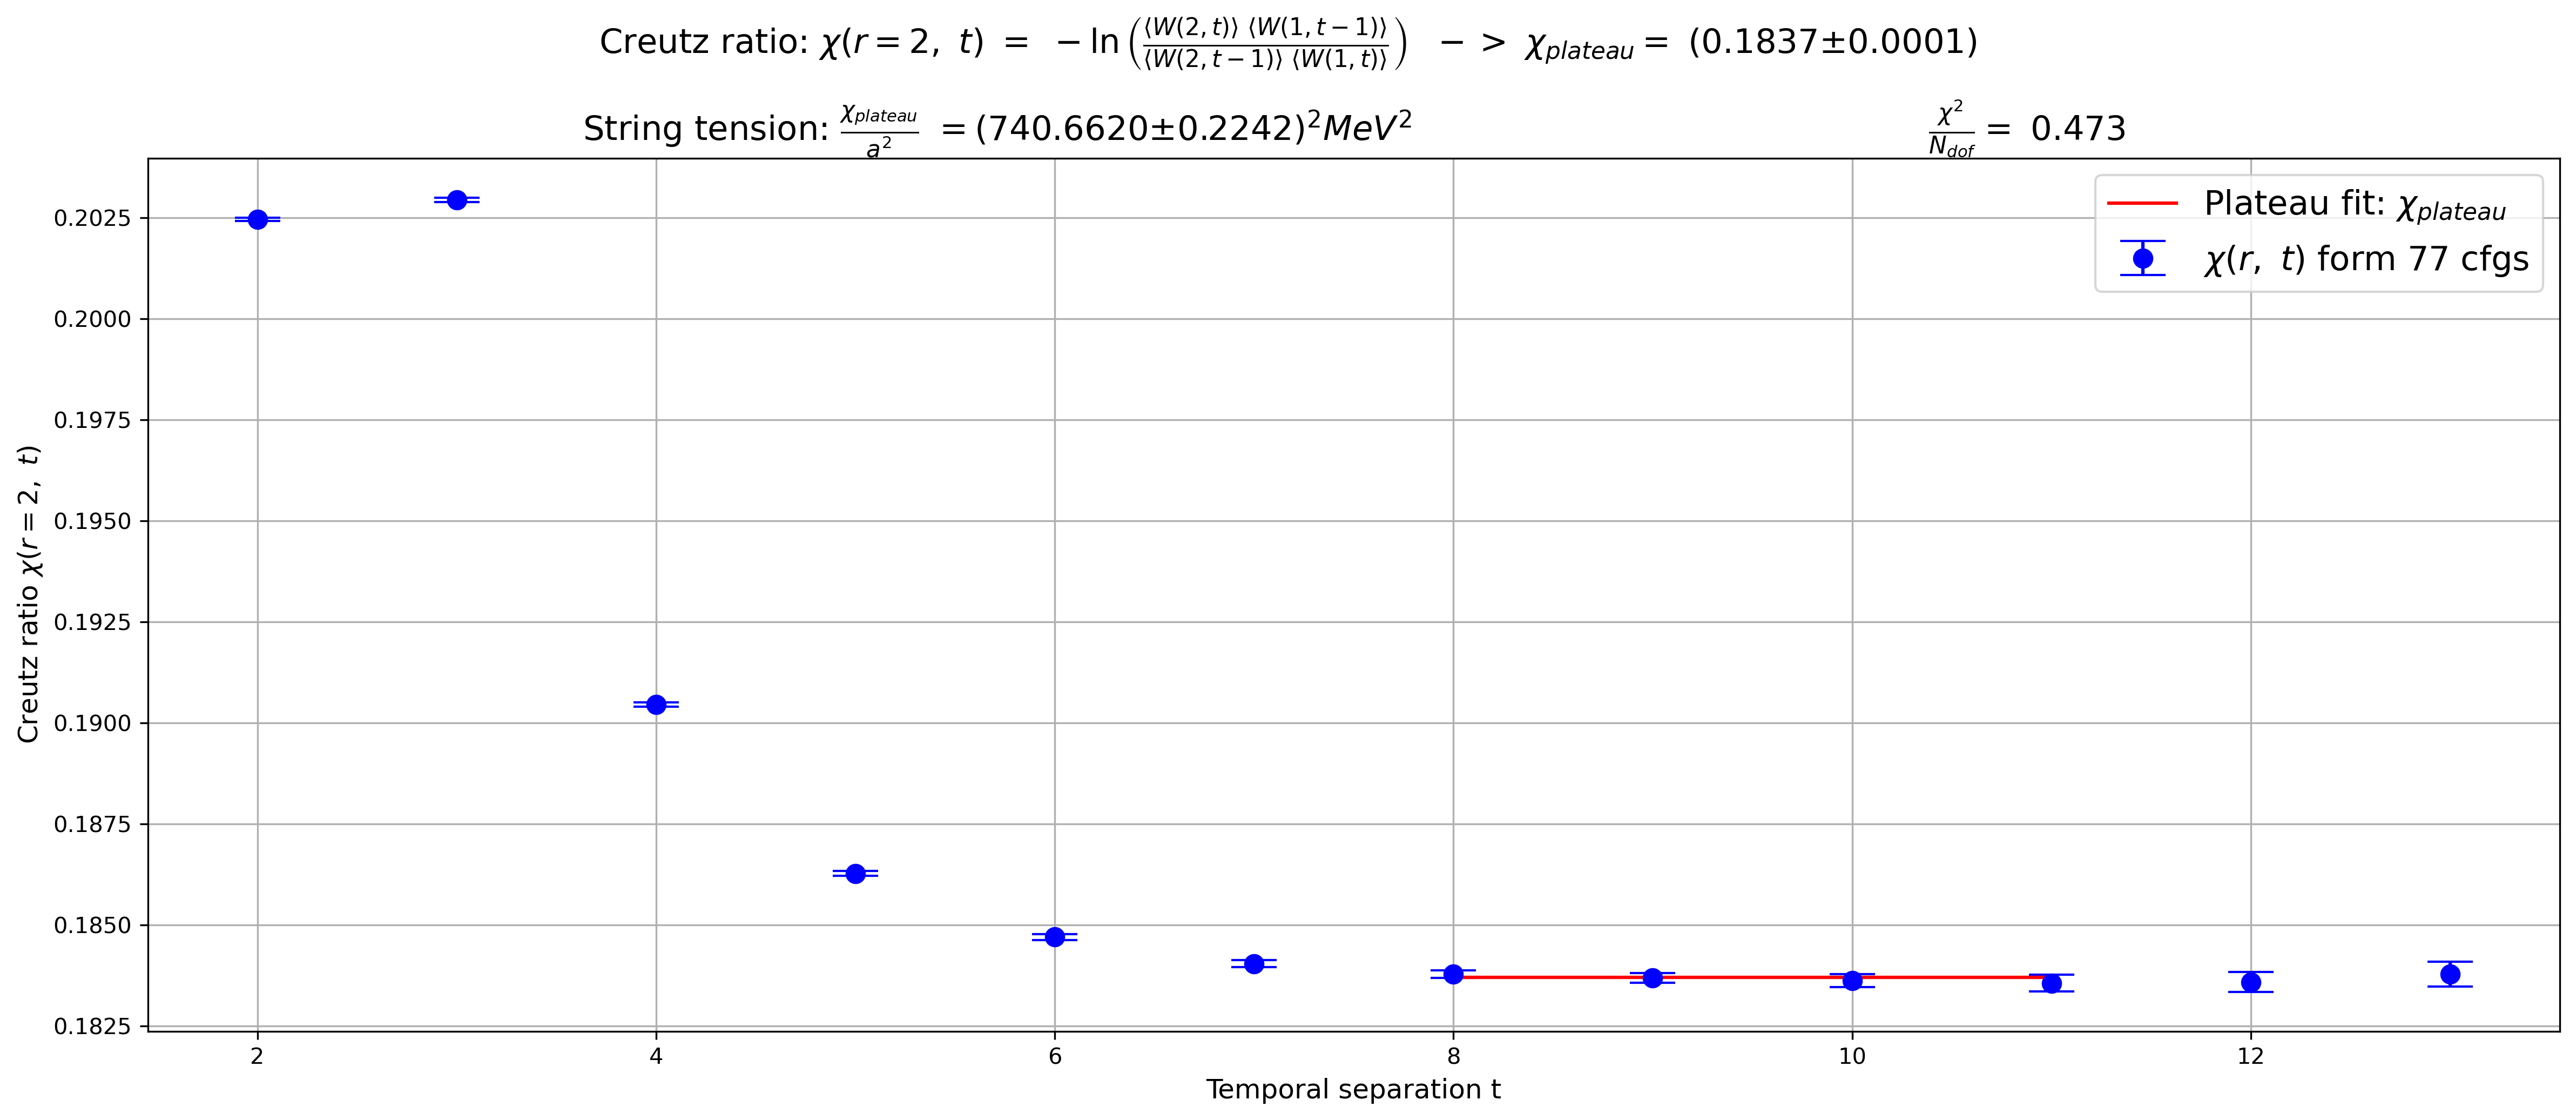

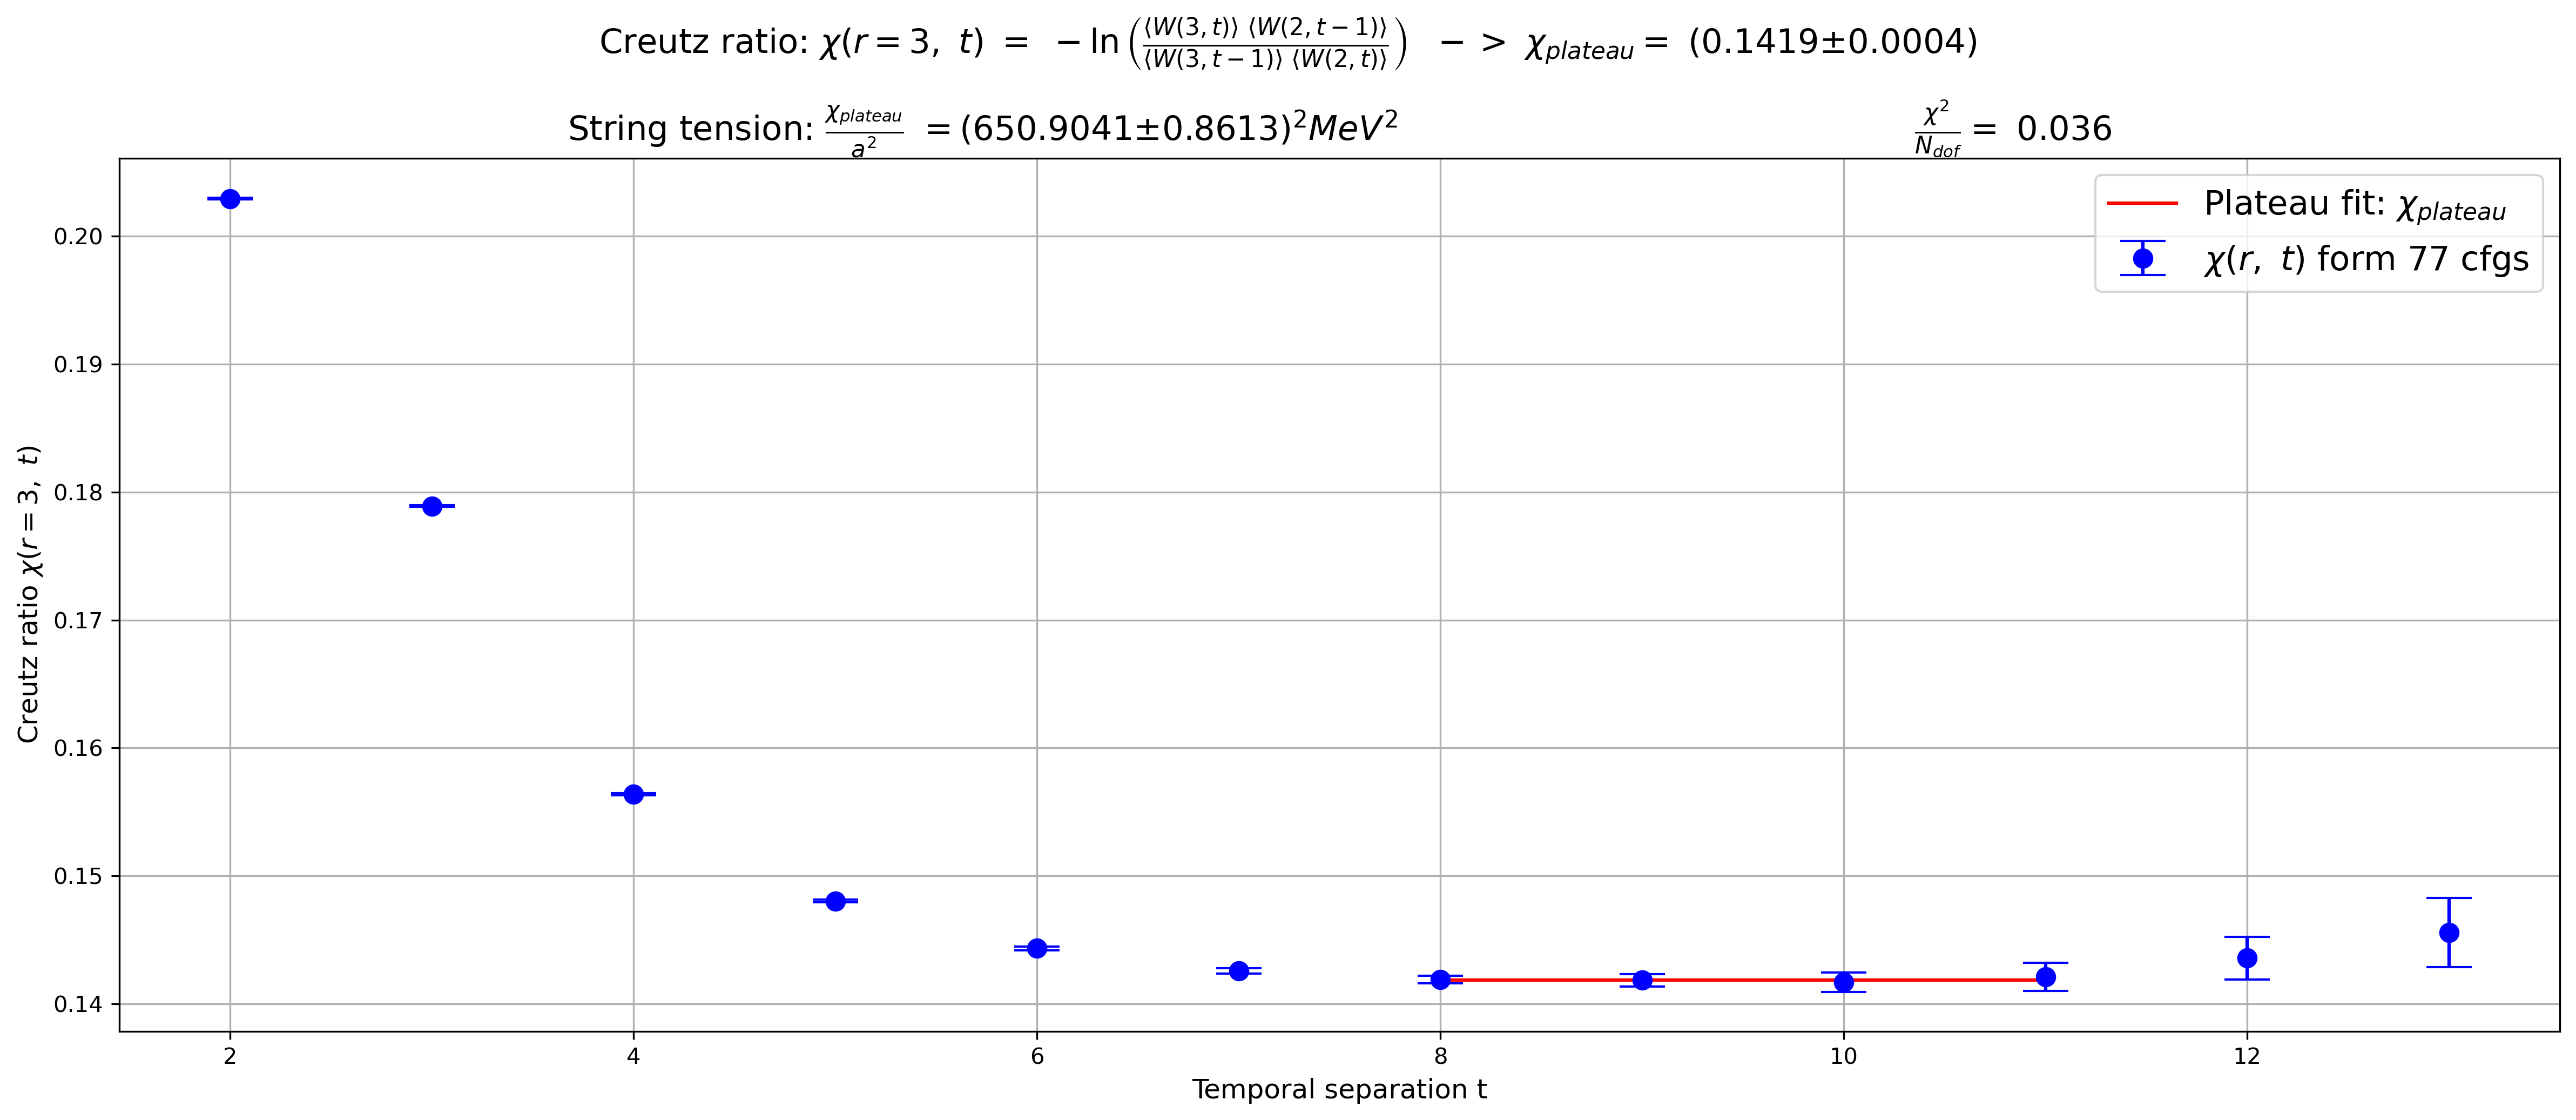

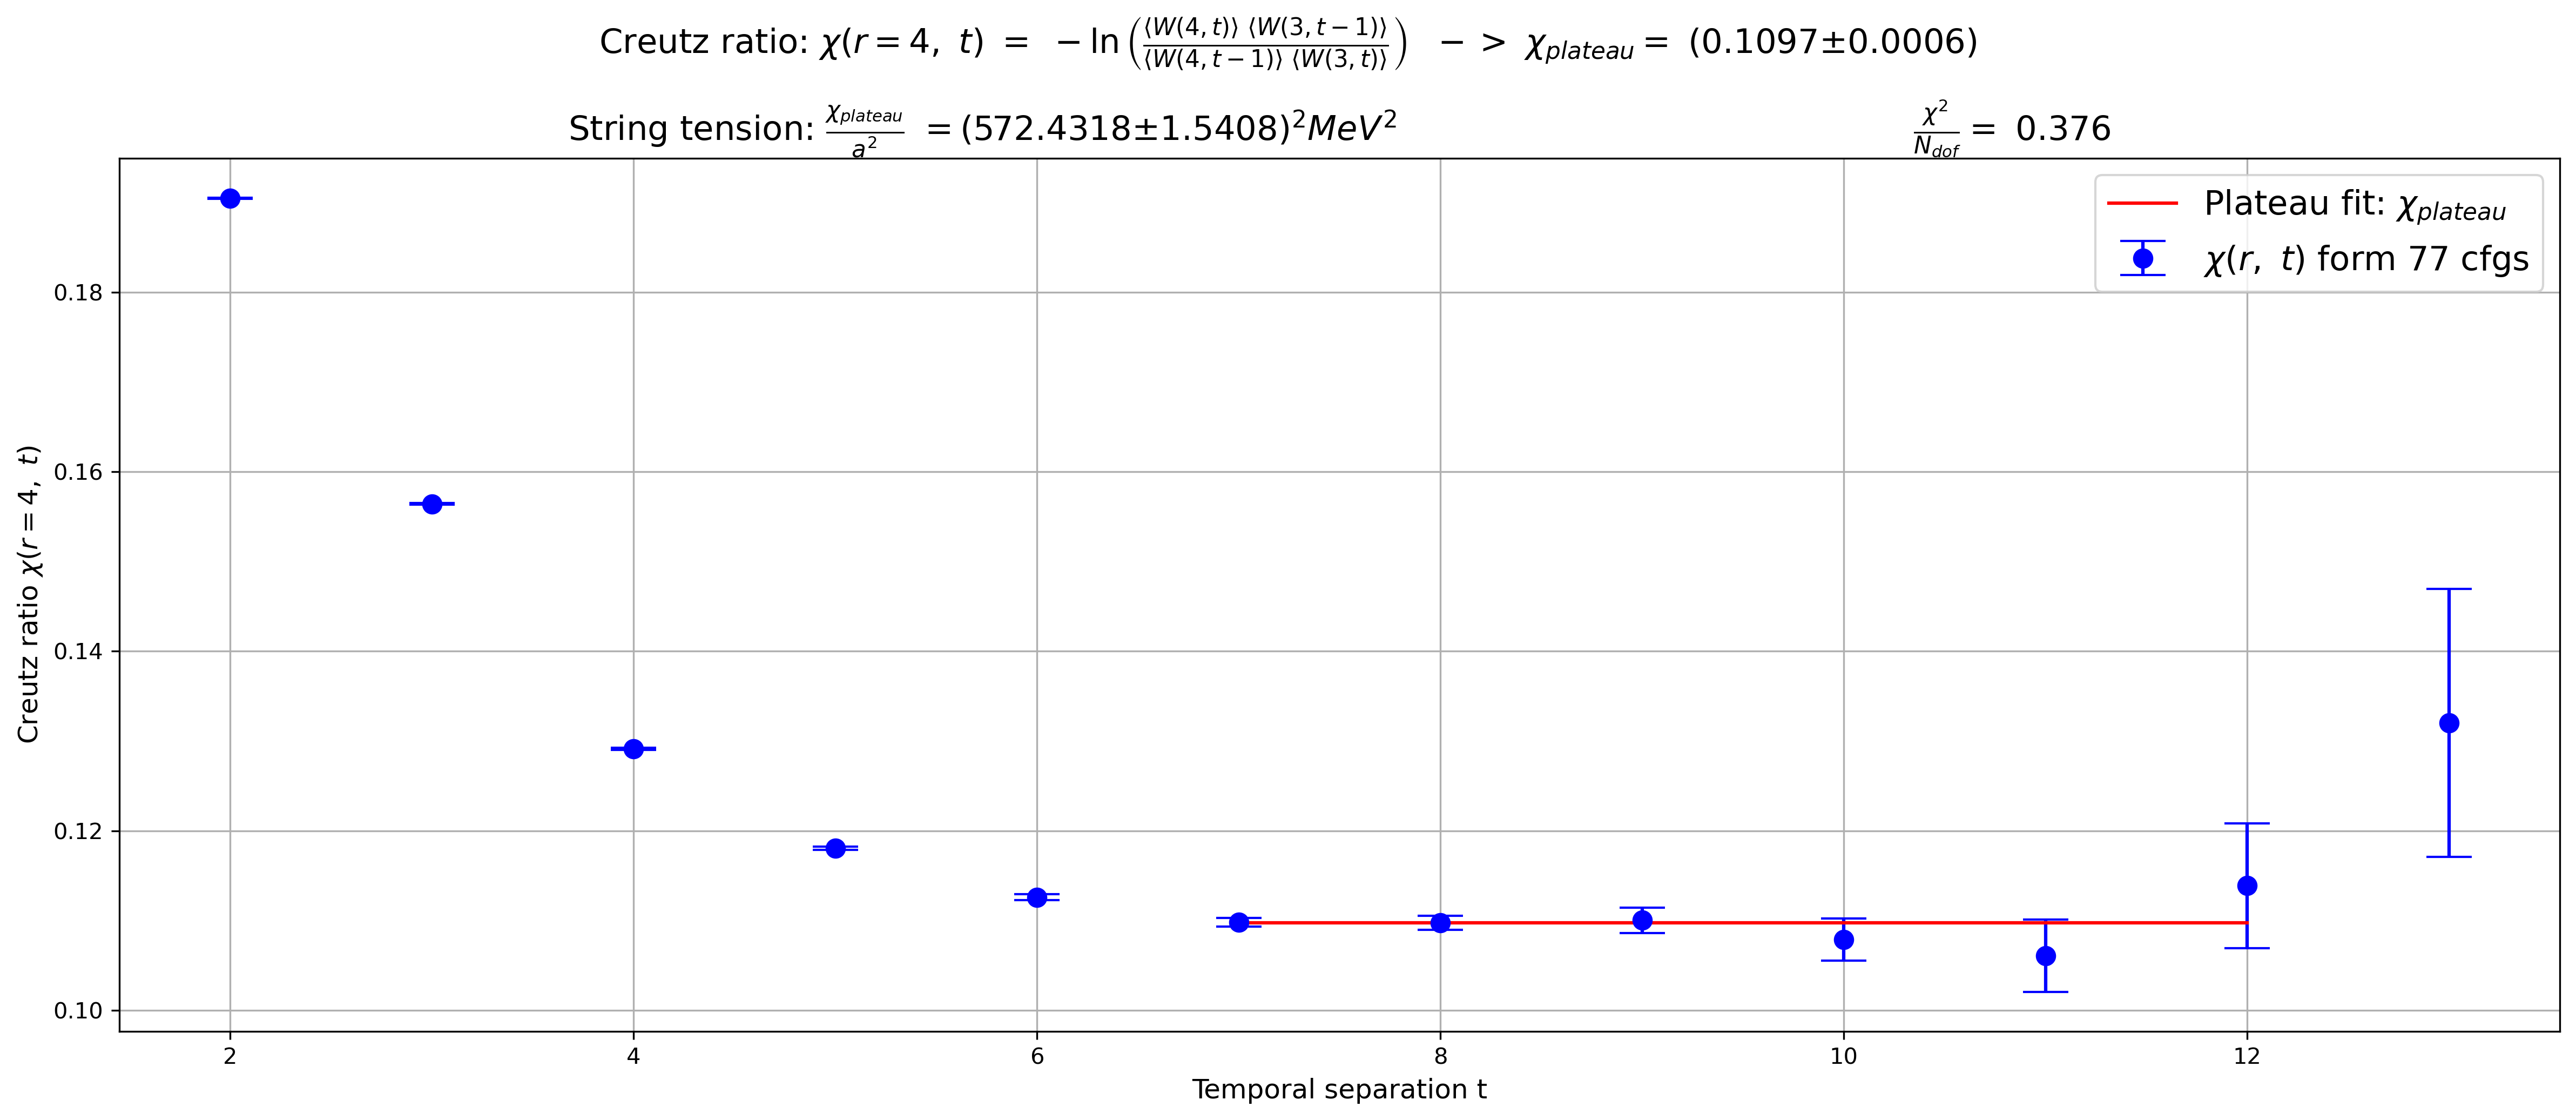

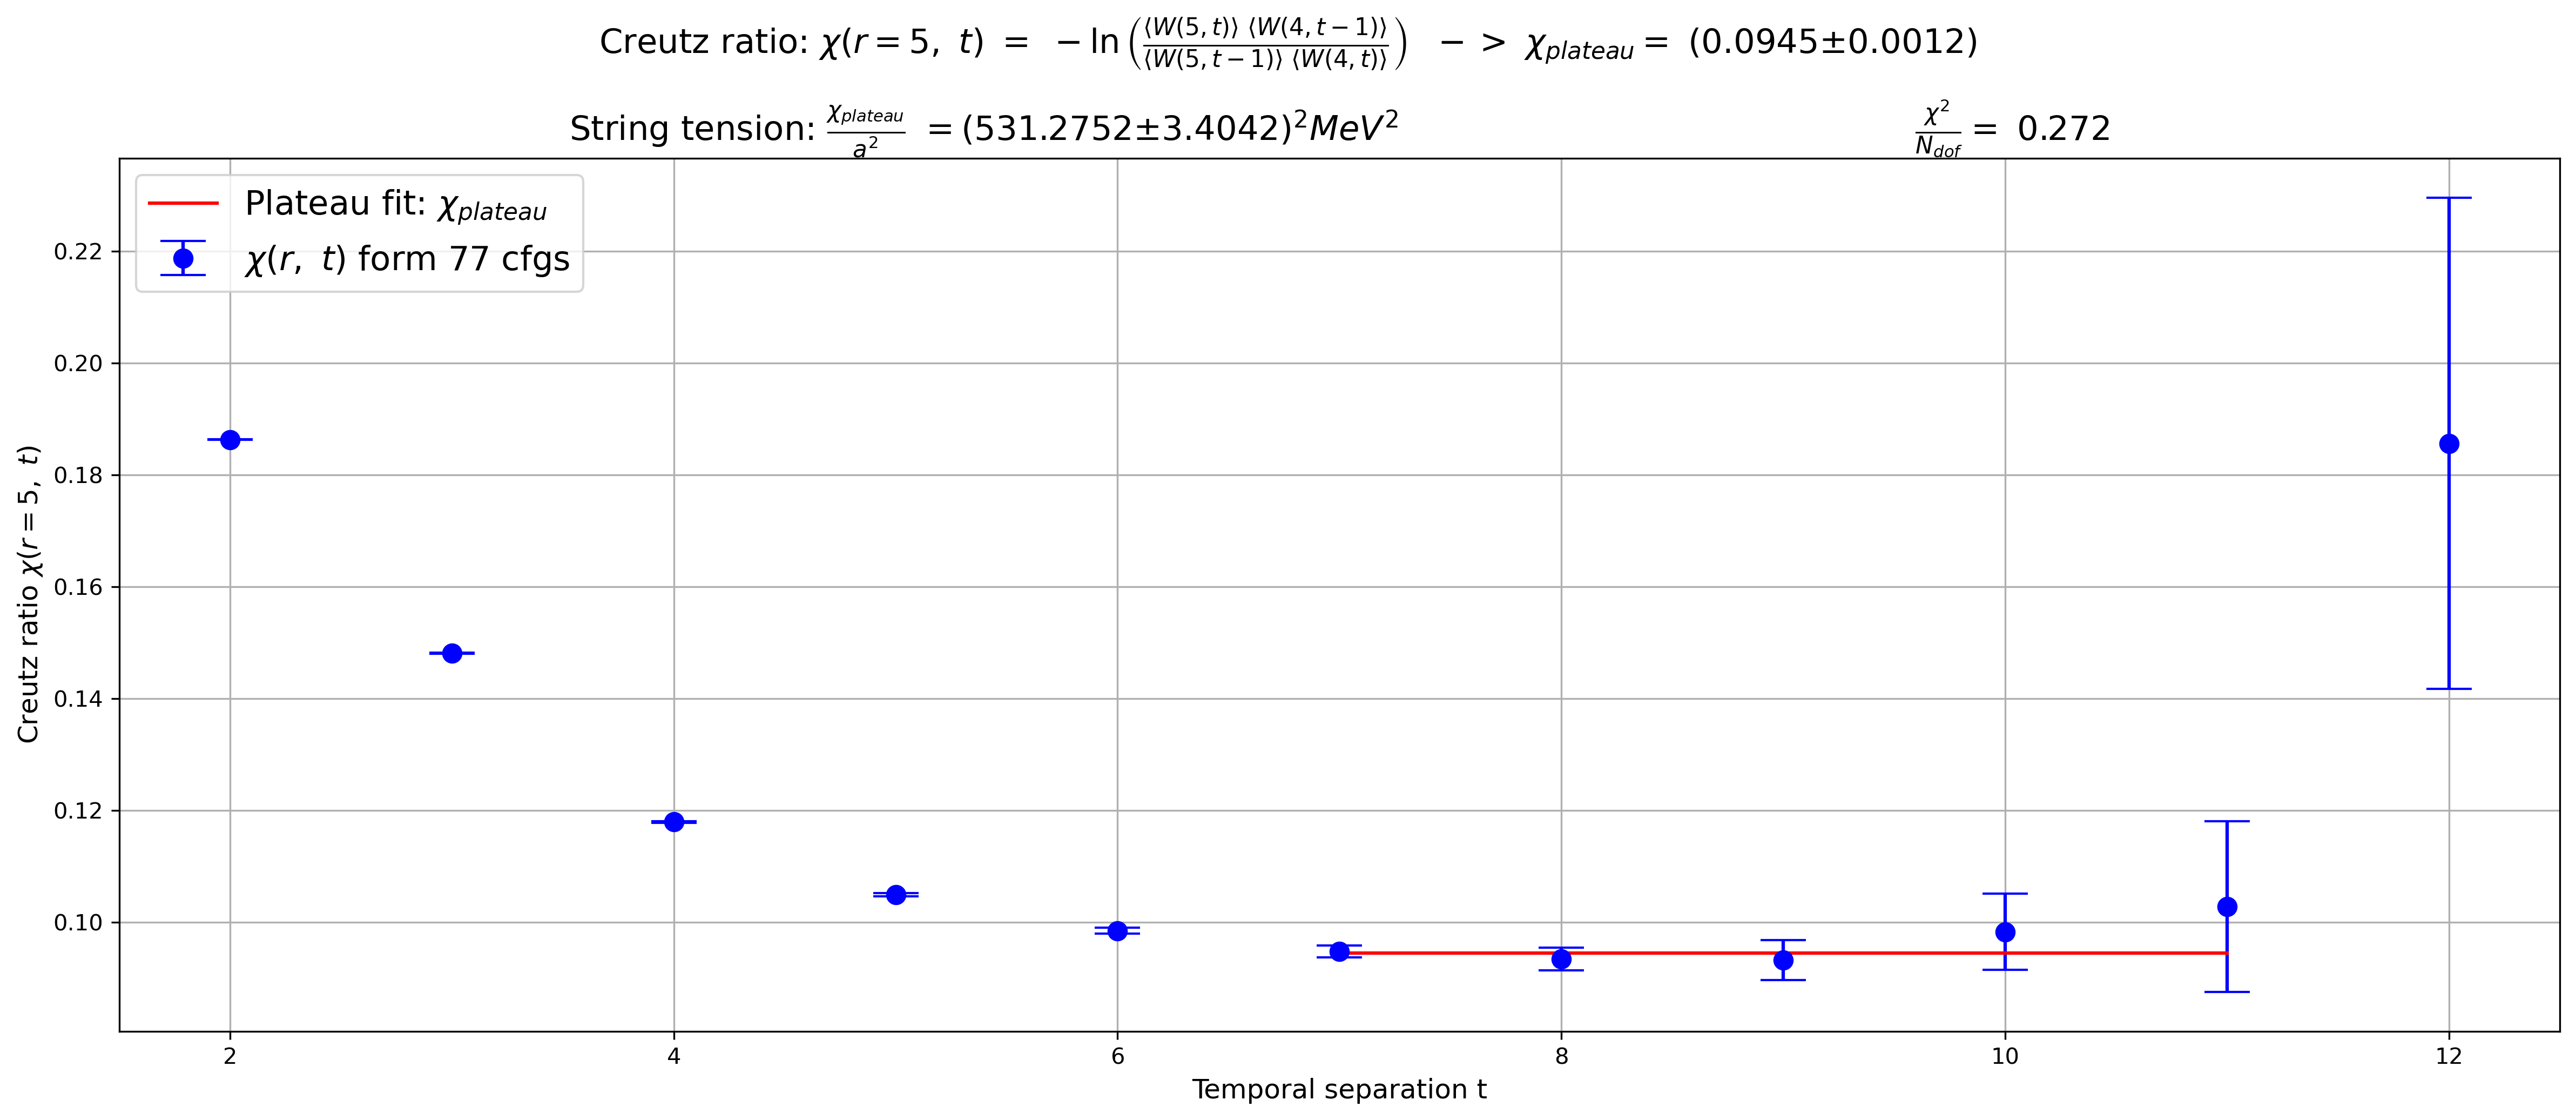

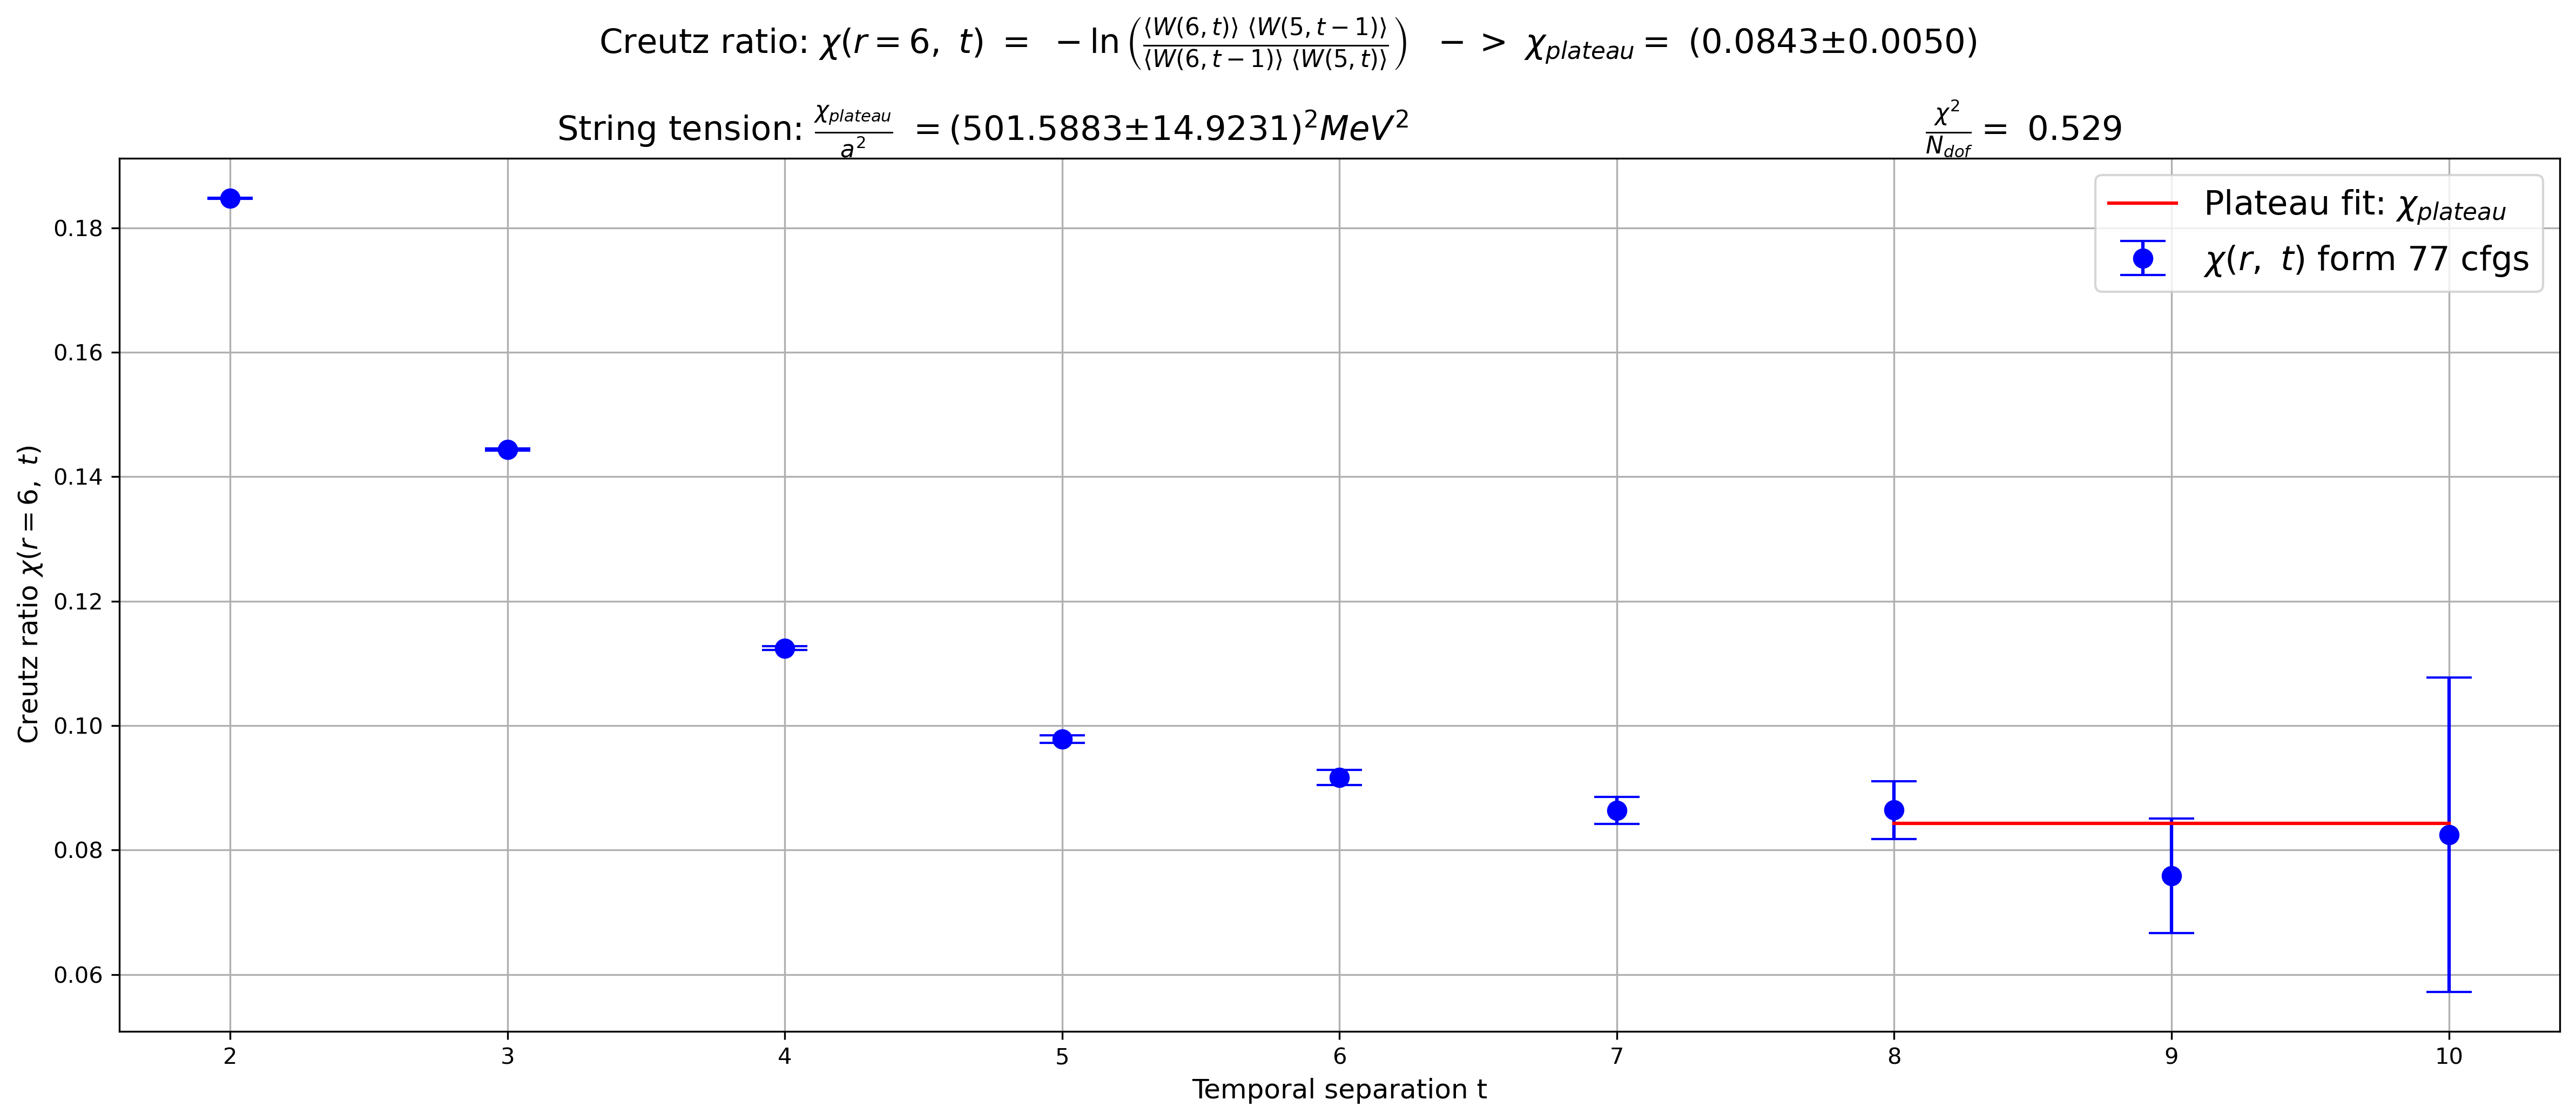

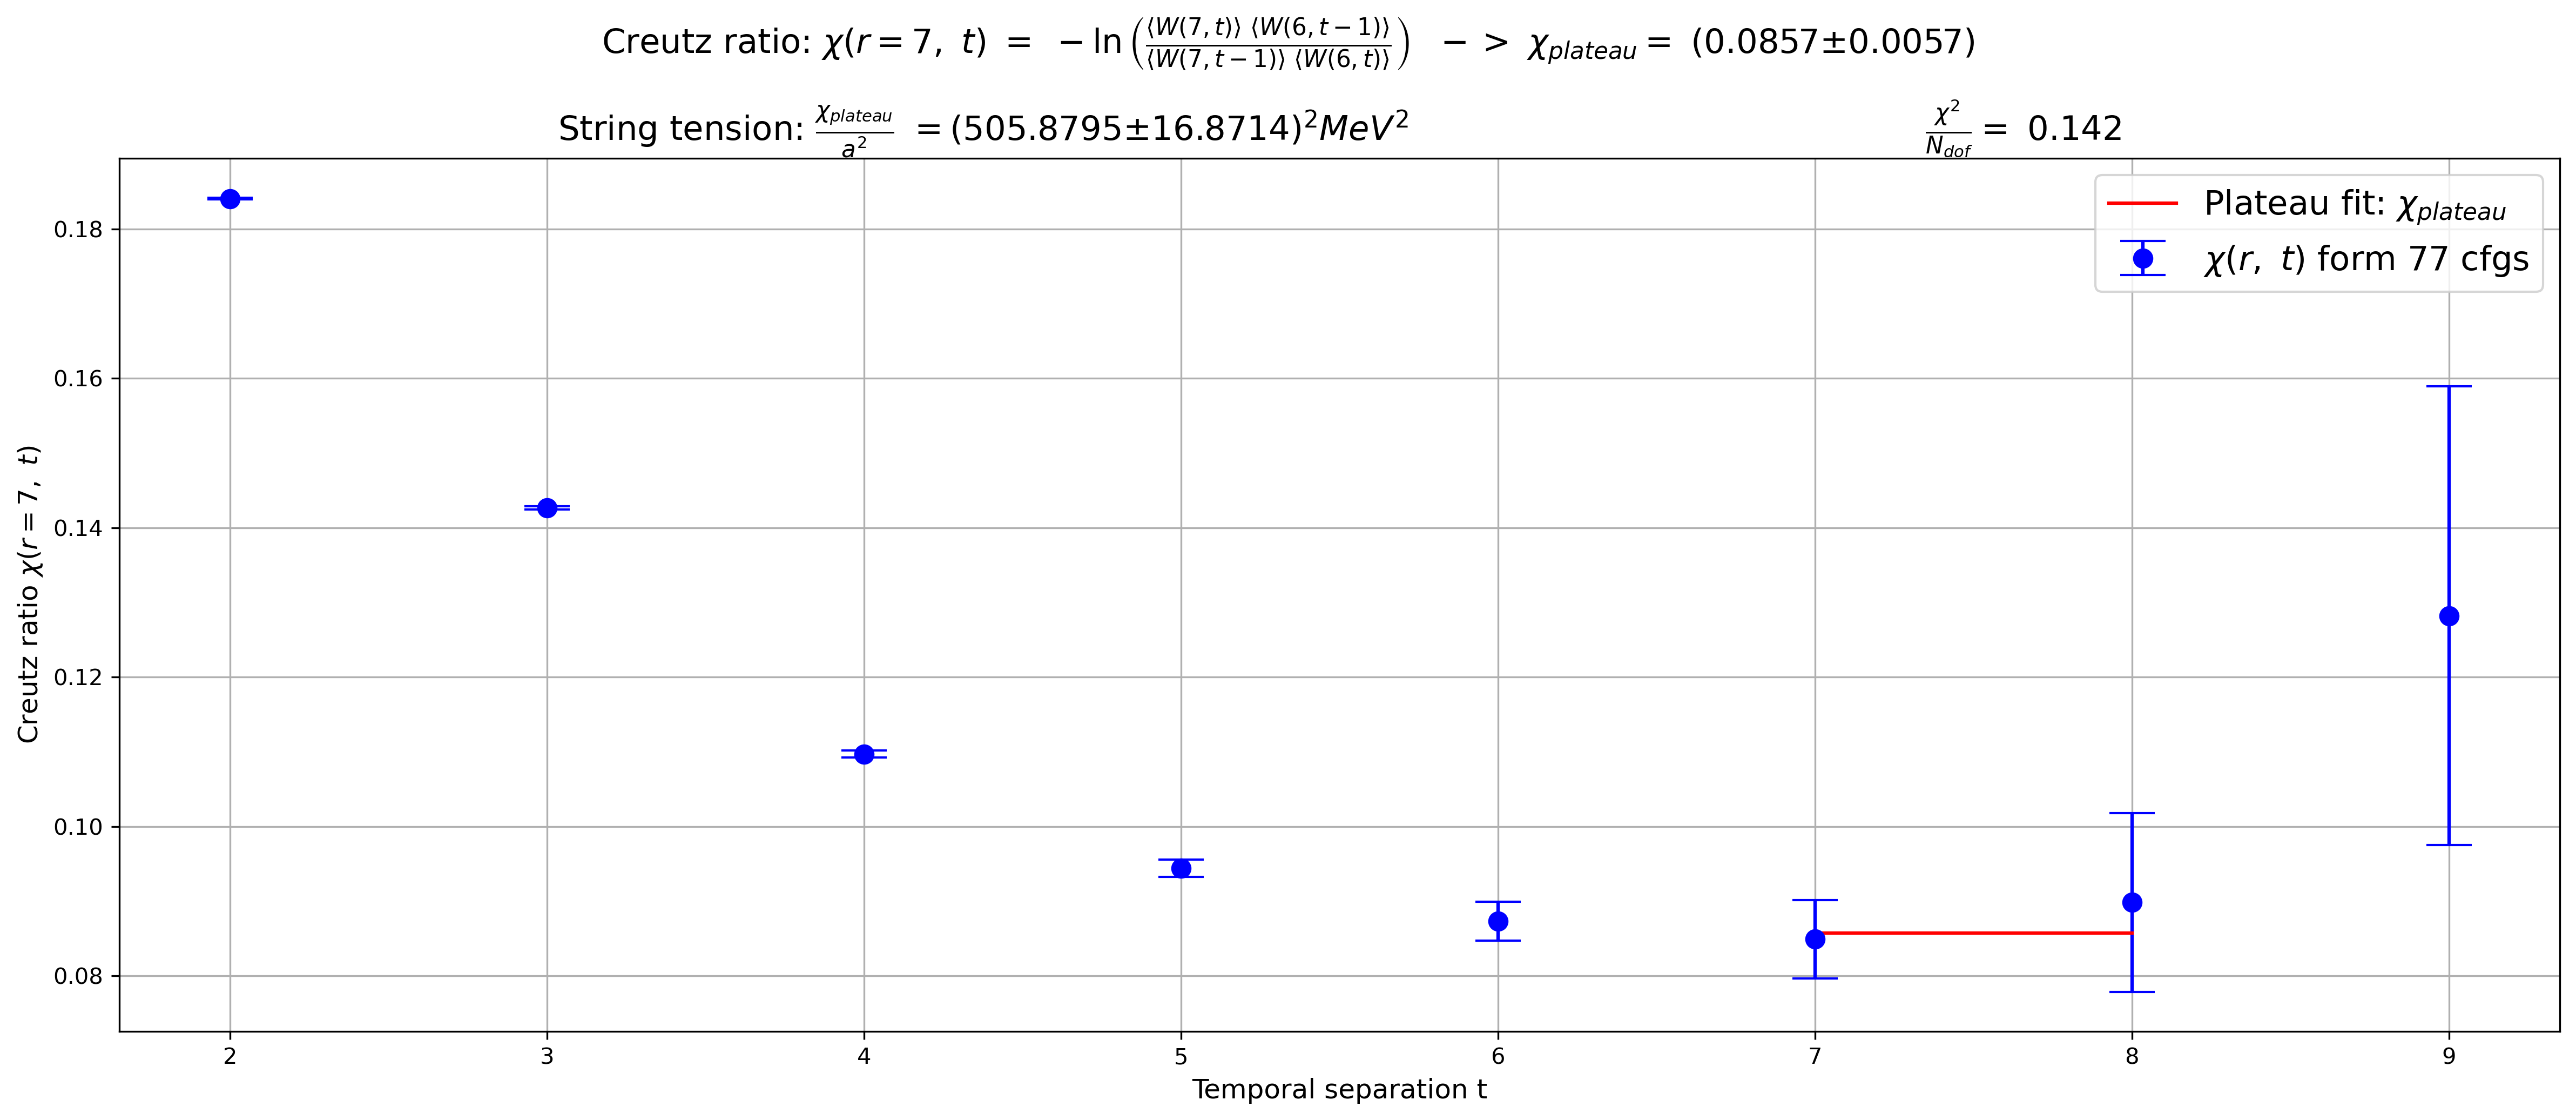

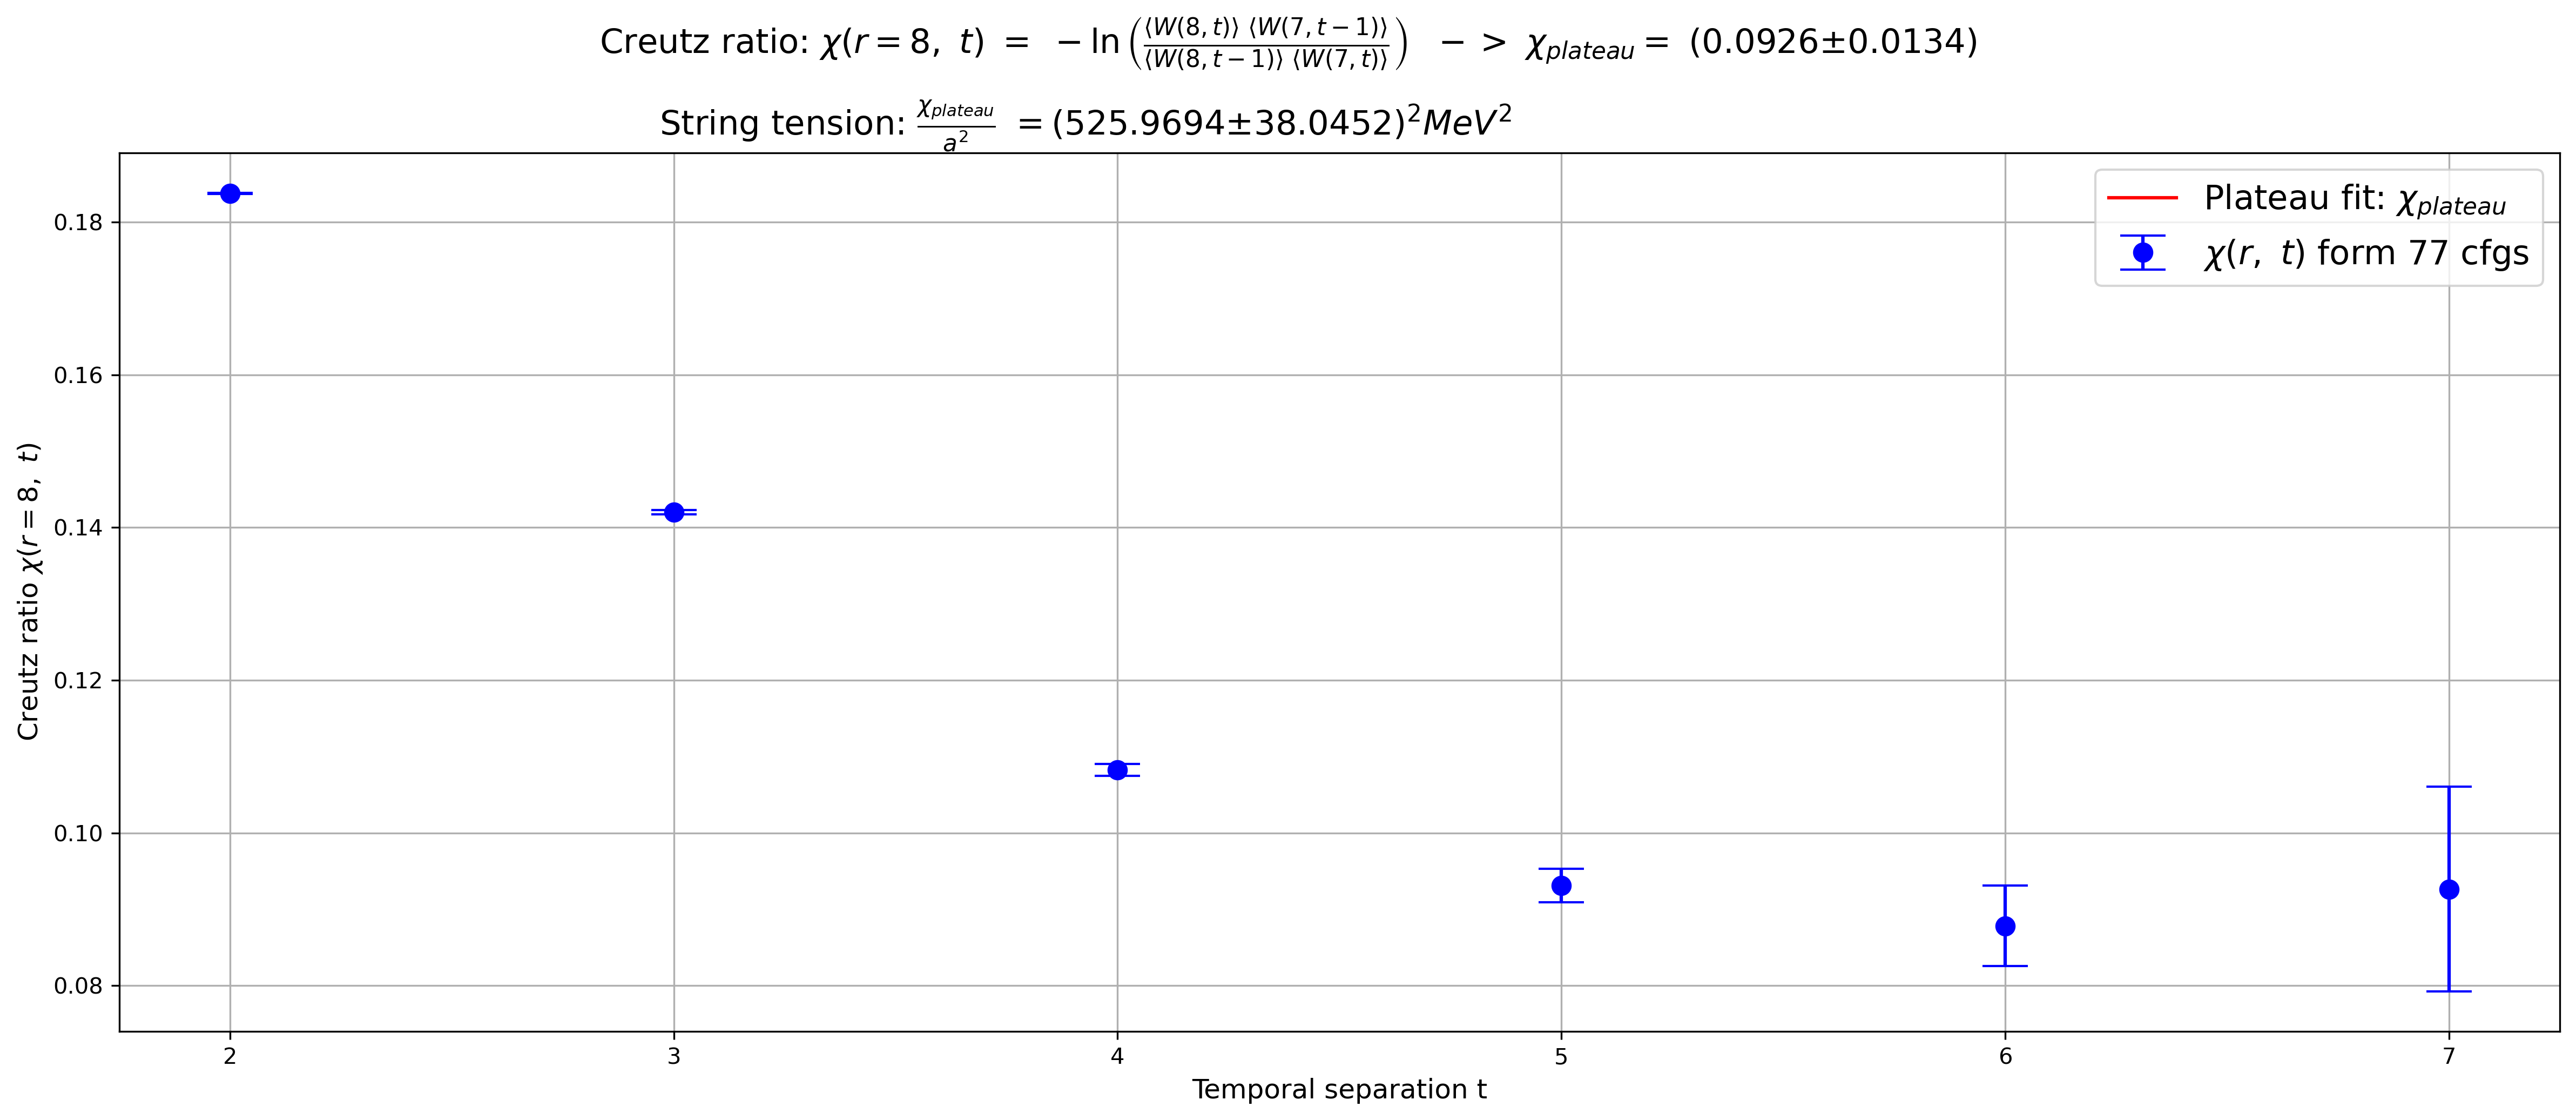

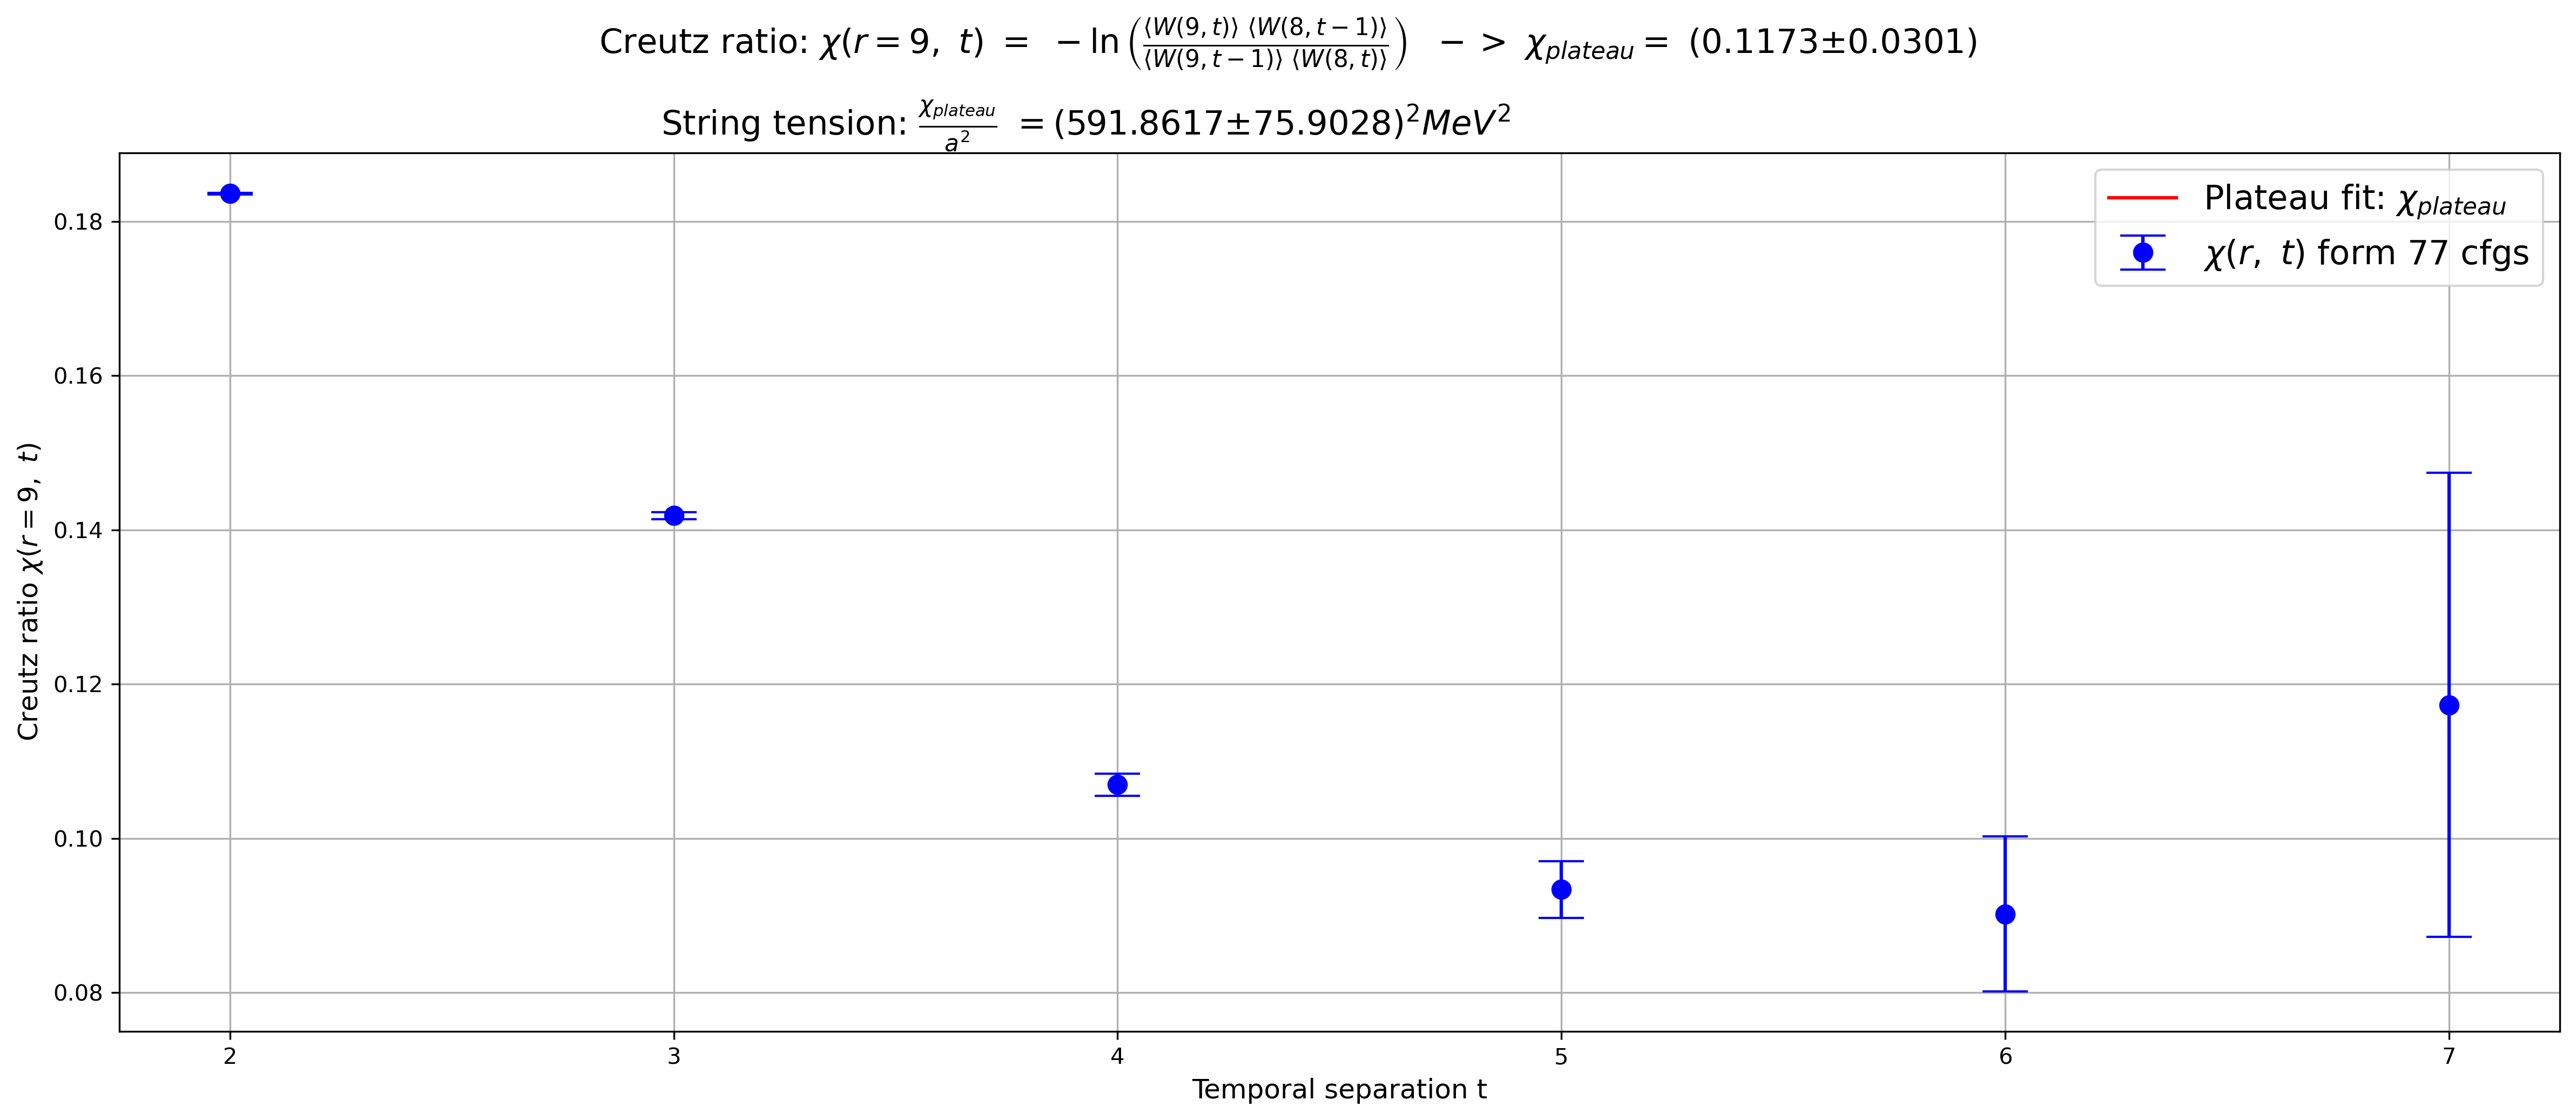

In [4]:
sigma_fit_r2, sigma_err_r2 = plot_chi_fiexd_r(r = 2, ti = 2, tf = 13, plateau_t_i = 8, plateau_t_f = 11)
sigma_fit_r3, sigma_err_r3 = plot_chi_fiexd_r(r = 3, ti = 2, tf = 13, plateau_t_i = 8, plateau_t_f = 11)
sigma_fit_r4, sigma_err_r4 = plot_chi_fiexd_r(r = 4, ti = 2, tf = 13, plateau_t_i = 7, plateau_t_f = 12)
sigma_fit_r5, sigma_err_r5 = plot_chi_fiexd_r(r = 5, ti = 2, tf = 12, plateau_t_i = 7, plateau_t_f = 11)
sigma_fit_r6, sigma_err_r6 = plot_chi_fiexd_r(r = 6, ti = 2, tf = 10, plateau_t_i = 8, plateau_t_f = 10)
sigma_fit_r7, sigma_err_r7 = plot_chi_fiexd_r(r = 7, ti = 2, tf = 9, plateau_t_i = 7, plateau_t_f = 8)
sigma_fit_r8, sigma_err_r8 = plot_chi_fiexd_large_r(r = 8, ti = 2, tf = 7, plateau_t_i = 7, plateau_t_f = 7)
sigma_fit_r9, sigma_err_r9 = plot_chi_fiexd_large_r(r = 9, ti = 2, tf = 7, plateau_t_i = 7, plateau_t_f = 7)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


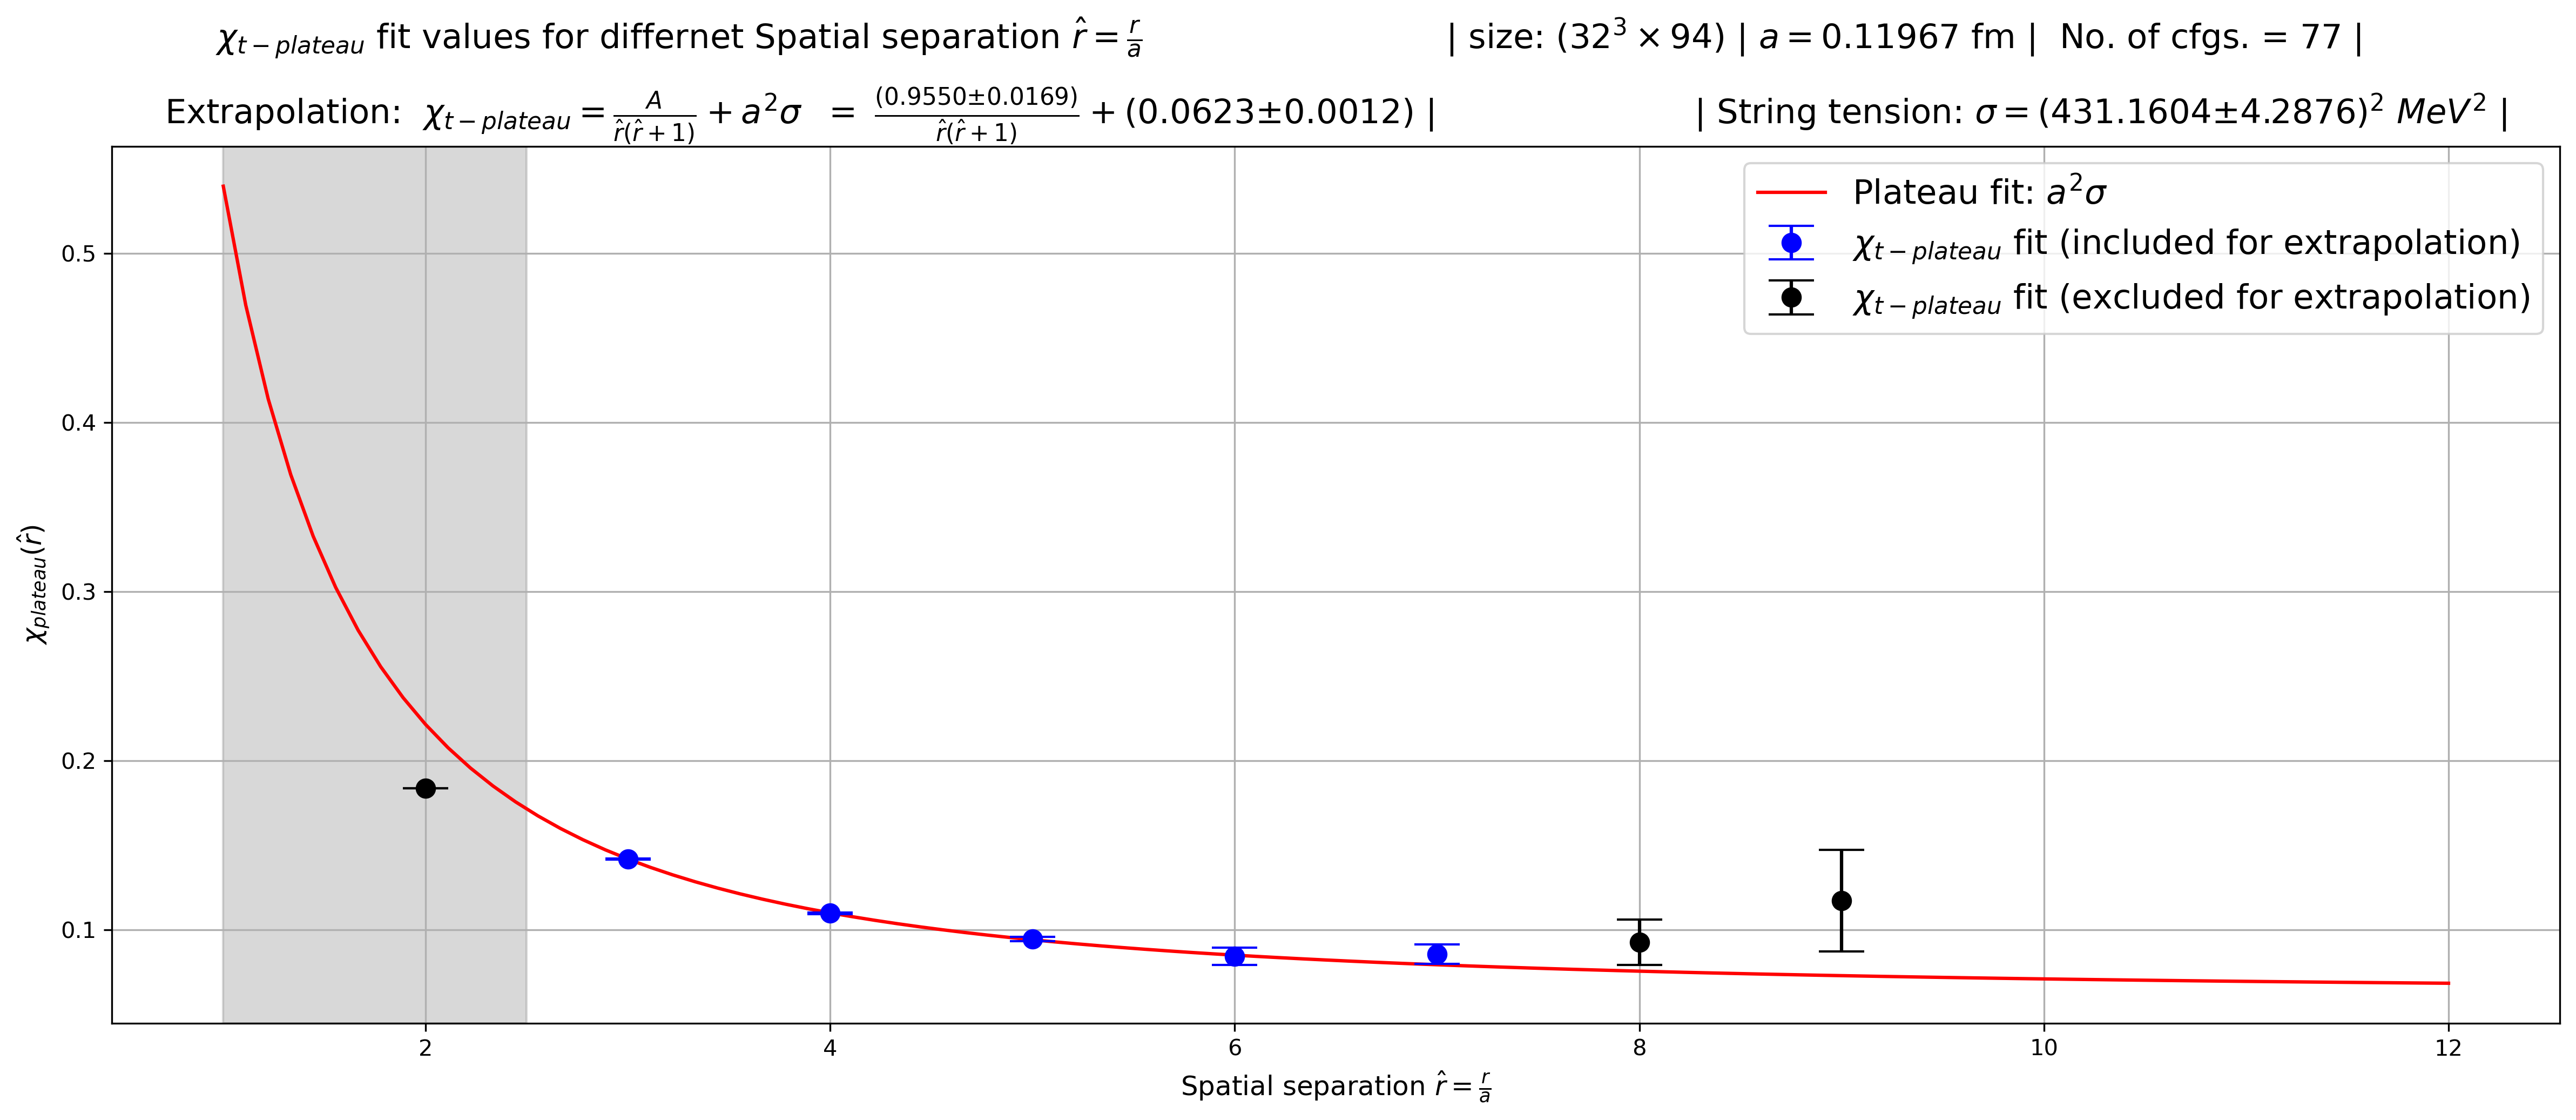

In [11]:
########### Extrapolation  ###################



def chi_fit(r, sigma_hat, c1):
    return sigma_hat+(c1/(r*(r+1)))


#extrapolation input points
p = 5

sigma_fit_list = [sigma_fit_r3, sigma_fit_r4, sigma_fit_r5, sigma_fit_r6, sigma_fit_r7, sigma_fit_r8, sigma_fit_r9]
sigma_fit_err_list = [ sigma_err_r3 ,sigma_err_r4, sigma_err_r5, sigma_err_r6, sigma_err_r7, sigma_err_r8, sigma_err_r9]
r_for_sigma_plot = [3,4,5,6,7,8,9]

sigma_fit_list1 = [sigma_fit_r2, sigma_fit_r3, sigma_fit_r4, sigma_fit_r5, sigma_fit_r6, sigma_fit_r7, sigma_fit_r8, sigma_fit_r9]
sigma_fit_err_list1 = [sigma_err_r2, sigma_err_r3 ,sigma_err_r4, sigma_err_r5, sigma_err_r6, sigma_err_r7, sigma_err_r8, sigma_err_r9]
r_for_sigma_plot1 = [2,3,4,5,6,7,8,9]
params_chifit, cov_chifit = curve_fit(chi_fit, r_for_sigma_plot[:p], sigma_fit_list[:p], sigma = sigma_fit_err_list[:p], absolute_sigma=True, maxfev=2000000)
sigma_hat_fit, c1_fit = params_chifit
sigma_hat_err, c1_err = np.sqrt(np.diag(cov_chifit))
x_curve_chi = np.linspace(1, 12, 100)
y_curve_chi = chi_fit(x_curve_chi, sigma_hat_fit, c1_fit)
tension_2CHI = np.sqrt((sigma_hat_fit*197*197)/(a*a))
tension_errCHI = ((sigma_hat_err*197*197)/(a*a))
tension_2_errCHI = (1/2)*(tension_errCHI/tension_2CHI)
plt.subplots(figsize=(16, 7),dpi=300)
plt.plot(x_curve_chi, y_curve_chi, 'r-', label='Plateau fit: $a^2\sigma$')
plt.errorbar(r_for_sigma_plot[:p], sigma_fit_list[:p], yerr=sigma_fit_err_list[:p], fmt='o', markersize=8, capsize=10, color='blue', label='$\chi_{t-plateau}$ fit (included for extrapolation)')
plt.errorbar(r_for_sigma_plot[p:], sigma_fit_list[p:], yerr=sigma_fit_err_list[p:], fmt='o', markersize=8, capsize=10, color='black', label='$\chi_{t-plateau}$ fit (excluded for extrapolation)')
plt.errorbar(r_for_sigma_plot1[0], sigma_fit_list1[0], yerr=sigma_fit_err_list1[0], fmt='o', markersize=8, capsize=10, color='black')
#plt.errorbar(r_for_sigma_plot, sigma_fit_list, yerr = sigma_fit_err_list, fmt='o', markersize=8, capsize=10, color='blue', label= '$a^2 \sigma$ fit')
plt.xlabel("Spatial separation $\hat{r}=\\frac{r}{a}$", fontsize=12)
plt.ylabel("$\chi_{plateau}(\hat{r})$", fontsize=12)
plt.legend(fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Extrapolation:  $\chi_{t-plateau}=\\frac{A}{\hat{r}(\hat{r}+1)}+a^2\sigma~~=~\\frac{(%.4f \u00B1 %.4f)}{\hat{r}(\hat{r}+1)}+(%.4f \u00B1 %.4f)$ |                        | String tension: $\sigma=(%.4f \u00B1 %.4f)^2~MeV^2$ |"%(c1_fit, c1_err, sigma_hat_fit, sigma_hat_err, tension_2CHI, tension_2_errCHI), fontsize=15)
plt.suptitle("$\chi_{t-plateau}$ fit values for differnet Spatial separation $\hat{r}=\\frac{r}{a}$                            | size: $(32^3\\times94)$ | $a = 0.11967$ fm |  No. of cfgs. = 77 |", fontsize=15)
plt.tight_layout()
plt.axvspan(1, 2.5, color='gray', alpha=0.3)
plt.grid(True)
plt.savefig('creutzratio.eps', dpi=5000)
plt.show()